##   IMPORTING LIBRARIES

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns; sns.set(style="whitegrid")
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

### DEFINING A FUNCTION TO CHECK THE COINTEGRATED STOCKS FROM THE UNIVERSE OF OUR COLLECTED STOCKS

In [10]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n,n))
    pvalue_matrix = np.ones((n,n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1,n):
            s1 = data[keys[i]]
            s2 = data[keys[j]]
            result = coint(s1,s2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i,j] = score
            pvalue_matrix[i,j] = pvalue
            if pvalue < 0.01:                #cutoff
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


### Forming a list of Stocks containing the Banks in India to check the Cointegration

In [17]:
banks = ['HDFCBANK.BO', 'AXISBANK.BO', 'SBIN.BO', 'ICICIBANK.BO', 'KOTAKBANK.BO', 'FEDERALBNK.BO', 'CENTRALBK.BO', 'PNB.BO']
data_bank = yf.download(banks,  start='2018-04-01', end='2019-03-31')
data_bank = data_bank['Close']
data_bank.head()

[*********************100%***********************]  8 of 8 completed


,AXISBANK.BO,CENTRALBK.BO,FEDERALBNK.BO,HDFCBANK.BO,ICICIBANK.BO,KOTAKBANK.BO,PNB.BO,SBIN.BO
Date,,,,,,,,
2018-04-02,498.200012,70.750000,90.199997,965.224976,261.899994,1097.400024,96.349998,246.300003
2018-04-03,503.299988,71.800003,91.500000,958.049988,269.600006,1103.000000,95.699997,250.350006
2018-04-04,490.149994,69.599998,91.400002,942.400024,268.450012,1078.199951,94.400002,246.899994
2018-04-05,503.149994,70.349998,93.550003,953.849976,277.899994,1114.599976,97.250000,258.399994
2018-04-06,500.700012,71.000000,97.199997,961.349976,280.600006,1119.099976,102.000000,259.799988


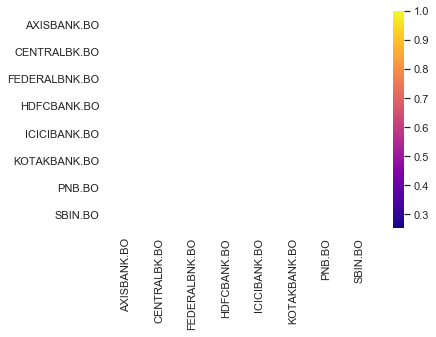

In [31]:
scores, pvalues, pairs = find_cointegrated_pairs(data_bank)
sns.heatmap(pvalues, xticklabels = data_bank.columns, yticklabels = data_bank.columns,
            cmap = 'plasma', mask = (pvalues >= 0.2))

### List of Stocks from IT Sector

In [19]:
tech = ['HCLTECH.NS', 'INFY.NS', 'TCS.NS']
data_tech = yf.download(tech,  start='2018-04-01', end='2019-03-31')
data_tech = data_tech['Close']
data_tech.head()

[*********************100%***********************]  3 of 3 completed


,HCLTECH.NS,INFY.NS,TCS.NS
Date,,,
2018-04-02,489.750000,568.575012,1454.819946
2018-04-03,484.625000,570.224976,1455.619995
2018-04-04,479.625000,562.099976,1455.449951
2018-04-05,481.024994,573.775024,1478.969971
2018-04-06,476.325012,563.500000,1475.150024


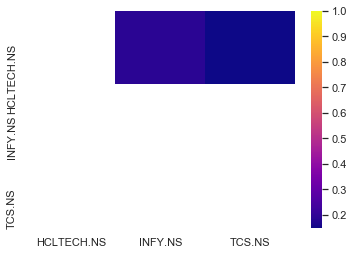

In [29]:
scores_2, pvalues_2, pairs_2 = find_cointegrated_pairs(data_tech)
sns.heatmap(pvalues_2, xticklabels = data_tech.columns, yticklabels = data_tech.columns,
            cmap = 'plasma', mask = (pvalues_2 >= 0.2))

In [30]:
coint_pairs = [('HCLTECH.NS', 'INFY.NS'), ('HCLTECH.NS', 'TCS.NS')]

for i in coint_pairs:
    S1 = data_tech[i[0]]
    S2 = data_tech[i[1]]
    score, pvalue, _ = coint(S1, S2)
    print(pvalue)

0.19048674836255997
0.14747488974603046


### We will experiment on HCL and TCS because of lower P-value

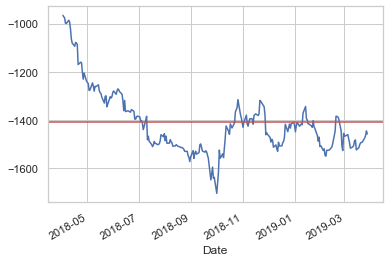

In [41]:
spread = data_tech['HCLTECH.NS'] - data_tech['TCS.NS']
spread.plot(label = 'Spread')
plt.axhline(spread.mean(),c = 'r')

In [36]:
#normalize stock prices
def zscore(stocks):
    return (stocks - stocks.mean())/np.std(stocks)

Text(0.5, 1.0, 'HCLTECH - TCS')

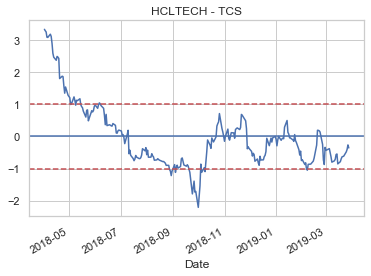

In [42]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(),c = 'b')
plt.axhline(1.0, c = 'r', ls = '--')
plt.axhline(-1.0, c = 'r', ls = '--')
plt.title("HCLTECH - TCS")

We can observe that the spread now has a mean of 0. Now we can use this series of z-scores to formulate a simple trading strategy. We have computed the spread to be share price of ‘HCLTECH’ minus share price of ‘TCS’. Now if the z-score > 1 , we will short HCLTECH and go long on TCS and if the z-score > -1, we will short TCS and go long on HCLTECH. If the z-score comes back to around 0, we will close our short/long position taken earlier.

However financial data is not static, we can’t trade in the future only knowing the variables at hand today. So for actually trading the algorithm we would be computing z-scores using a 20 day rolling mean and a 20 day rolling standard deviation.

In [44]:
spread_mavg1 = spread.rolling(1).mean()
spread_mavg20 = spread.rolling(20).mean()
spread_std20 = spread.rolling(20).std()
zscore_20_1 = (spread_mavg1 - spread_mavg20)/spread_std20

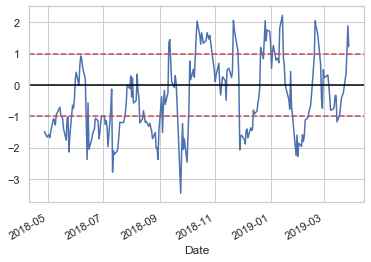

In [45]:
zscore_20_1.plot(label = 'Rolling 20 day z score')
plt.axhline(0,color = 'black')
plt.axhline(1, c ='r',ls='--')
plt.axhline(-1, c ='r',ls='--')

Thus, this is a basic pairs trading strategy which could be improved by taking a larger universe of stocks to select from, creating more pairs, conducting more statistical tests and other means; however the goal remains to go long on one asset/group of assets and short on one asset/group of assets and try to generate returns from the deviations of the spread from the mean. After creating a strategy it is essential to backtest the strategy with out-of-sample dates to ascertain the robustness and strength of the strategy.

## A detailed notebook on PAIR TRADING 

https://github.com/KidQuant/Pairs-Trading-With-Python/blob/master/PairsTrading.ipynb

## Read more about Optimal Threshold Strategies :

https://www.uv.es/bfc/TFM%202018/18.%20Alejandro%20Alvarez.pdf